## CT Volume Preprocessing and Mask Creation (Summary)

This notebook processes a 3D CT knee scan using classical image processing to generate a clean binary mask.

- Loaded CT volume with `nibabel`, extracted voxel data and spacing.
- Visualized slices and initialized a zero binary mask.
- Applied slice-wise masking with zoom, Gaussian blur, and thresholding.
- Post-processed masks by filling holes and removing small objects.
- Verified zoom operations with histogram and equality checks.
- Saved the final cleaned mask as a NIfTI file.

---

**Next steps:** segmentation, contour adjustment, and landmark detection.


In [1]:
# Standard & Core Libraries
import numpy as np
import matplotlib.pyplot as plt

# Scientific Computation & Image Processing
import scipy.ndimage as ndi
from scipy.ndimage import (
    zoom,
    binary_fill_holes,
    distance_transform_edt,
)

# Morphological Operations & Segmentation
from skimage.morphology import (
    skeletonize,
    opening,
    remove_small_objects,
    disk
)
from skimage.segmentation import watershed
from skimage.filters import gaussian
from skimage.feature import peak_local_max
from skimage.measure import find_contours

# Medical Image I/O & Visualization
import nibabel as nib
import cv2
from mayavi import mlab


In [2]:
# Load CT volume and extract metadata
ct_volume = nib.load("../results/3702_left_knee.nii.gz")          # Load the .nii file
ct_data = ct_volume.get_fdata()                                   # Extract the 3D image data as a NumPy array
spacing = ct_volume.header.get_zooms()                            # Get voxel spacing in (x, y, z) format

# Print basic volume info
print("Volume shape:", ct_data.shape)
print("Voxel spacing (x, y, z):", spacing)


Volume shape: (512, 512, 216)
Voxel spacing (x, y, z): (np.float32(0.869141), np.float32(0.869141), np.float32(2.0))


In [3]:
def show_mask(mask, title="Mask", show_axis=False):
    """
    Display a binary mask using matplotlib.

    Parameters:
        mask (ndarray): 2D binary mask to display.
        title (str): Title of the plot.
        show_axis (bool): Whether to display axis ticks and labels.
    """
    plt.imshow(mask, cmap="gray")
    plt.title(title)
    if not show_axis:
        plt.axis("off")
    plt.show()

In [ ]:
import ipywidgets as widgets
from IPython.display import display

def explore_slices(volume):
    def view_slice(slice_index):
        show_mask(volume[:, :, slice_index], title=f"CT Slice {slice_index}")
    
    slider = widgets.IntSlider(min=0, max=volume.shape[2] - 1, step=1, value=80)
    widgets.interact(view_slice, slice_index=slider)

# Explore the CT volume slice by slice
explore_slices(ct_data)


interactive(children=(IntSlider(value=80, description='slice_index', max=215), Output()), _dom_classes=('widge…

In [5]:
# Initialize an empty binary mask with the same shape as the CT volume
binary_mask = np.zeros_like(ct_data)

In [9]:
def mask_slice(i, threshold_value=180, sigma=2, zoom_factor=4):
    """
    Create a binary mask for a specific slice index in the CT volume.

    Parameters:
        i (int): Slice index to process.
        threshold_value (int): Intensity threshold for binarization.
        sigma (float): Gaussian blur sigma value.
        zoom_factor (int or float): Factor to zoom in before processing.

    Returns:
        np.ndarray: A binary mask for the given slice.
    """
    # Extract the slice
    ct_slice = ct_data[:, :, i]

    # Upsample to improve resolution for thresholding
    zoom_in = zoom(ct_slice, (zoom_factor, zoom_factor), order=0)

    # Apply Gaussian blur to reduce noise
    blurred = gaussian(zoom_in, sigma=sigma)

    # Thresholding to create binary mask
    _, thresh = cv2.threshold(blurred, threshold_value, 255, cv2.THRESH_BINARY)

    # Downsample to original shape
    zoom_out = zoom(thresh, (1/zoom_factor, 1/zoom_factor), order=0)

    return zoom_out


In [12]:
# Define the range of slices to process
start_slice, end_slice = 130, 216

for i in range(start_slice, end_slice):
    # Generate mask from the slice
    mask = mask_slice(i)

    # Fill internal holes
    filled_mask = binary_fill_holes(mask)

    # Optional: Apply morphological opening to remove small artifacts
    # opening = binary_opening(filled_mask, disk(1), mode="ignore")

    # Remove small objects to clean up the mask
    clean_mask = remove_small_objects(filled_mask.astype(bool), min_size=800)

    # Optional: Distance transform + watershed for complex overlapping regions
    # Recommended for slices 91–93 (commented for now)
    # distance = distance_transform_edt(clean_mask, sampling=spacing[:2])
    # coords = peak_local_max(distance, footprint=np.ones((10, 10)), labels=clean_mask)
    # markers = np.zeros_like(distance, dtype=bool)
    # markers[tuple(coords.T)] = True
    # markers, _ = ndi.label(markers)
    # labels = watershed(-distance, markers, mask=clean_mask)
    # labels[labels == 2] = 0  # Keep only label 1

    # Store the mask in the binary volume
    binary_mask[:, :, i] = clean_mask.astype(np.uint8)


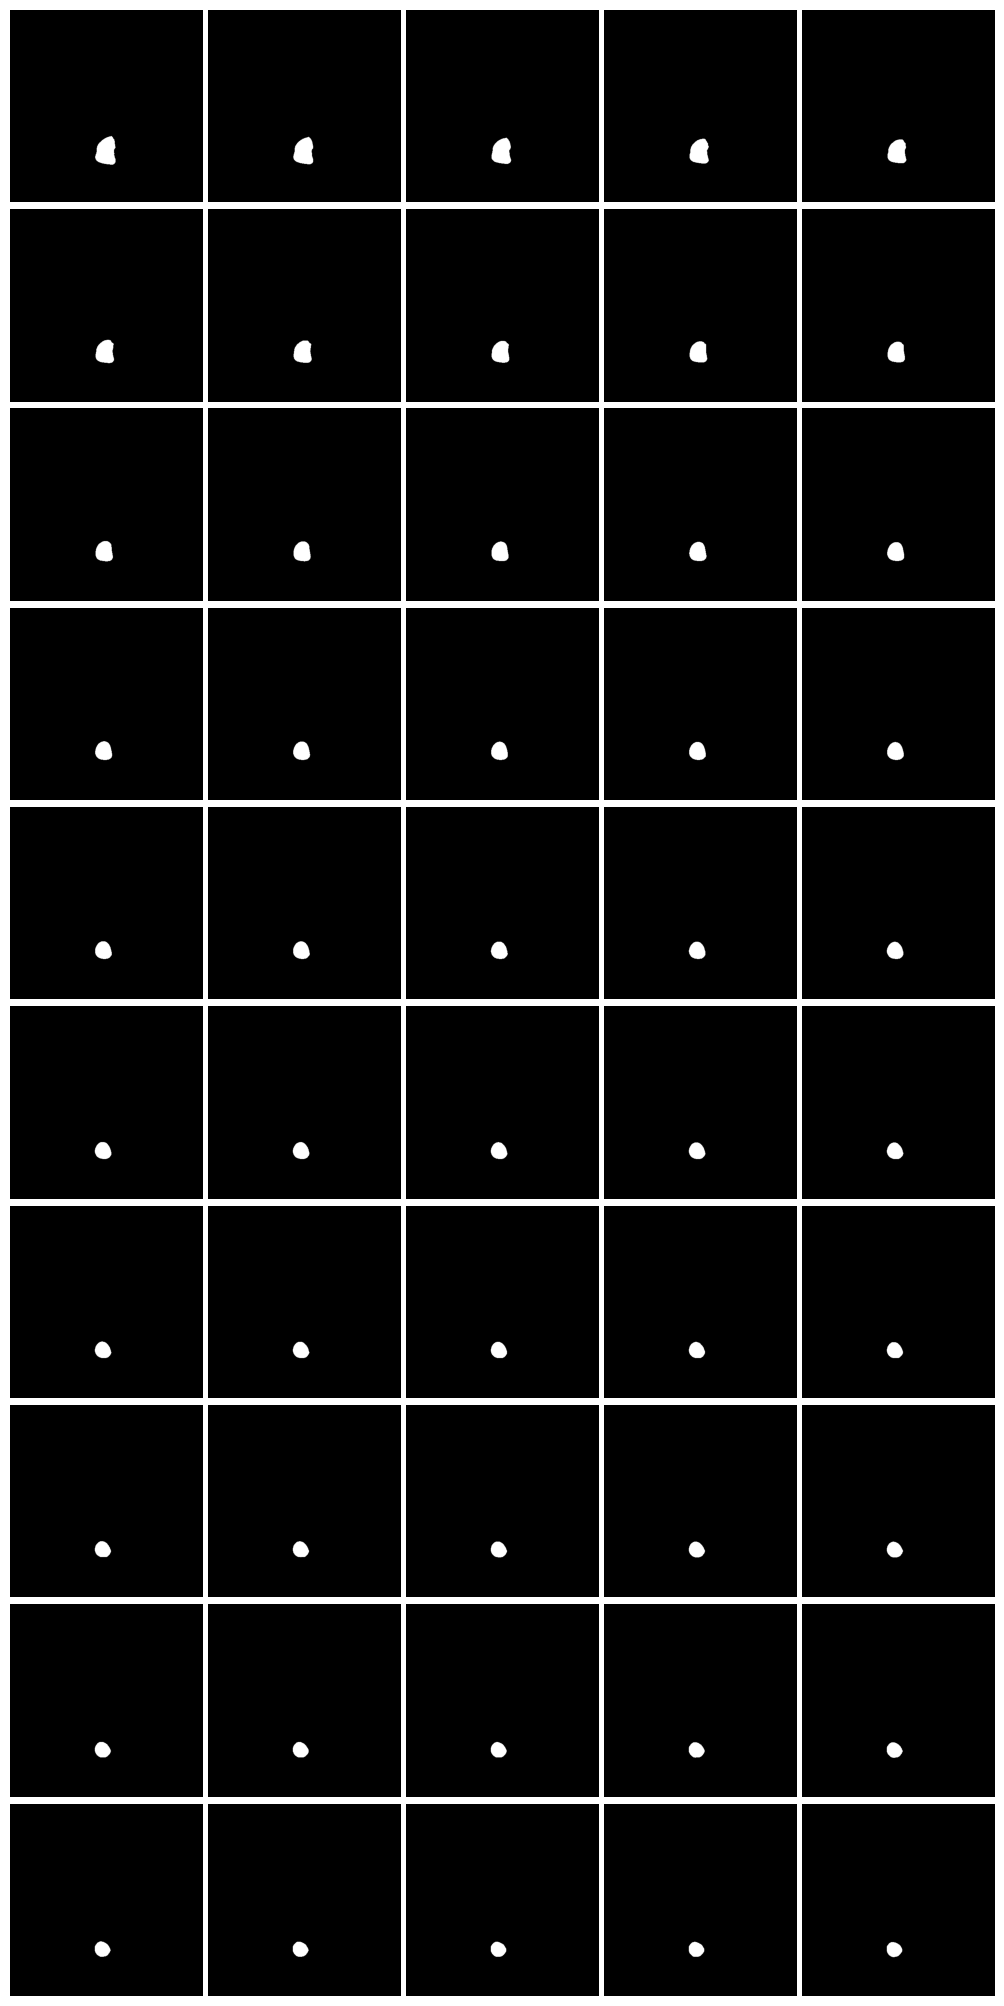

In [16]:
fig, axes = plt.subplots(10, 5, figsize=(10, 20))
for i, ax in enumerate(axes.flat):
    ax.imshow(binary_mask[:, :, 130 + i], cmap="gray")
    ax.axis("off")
plt.tight_layout(pad=0.5)
plt.show()

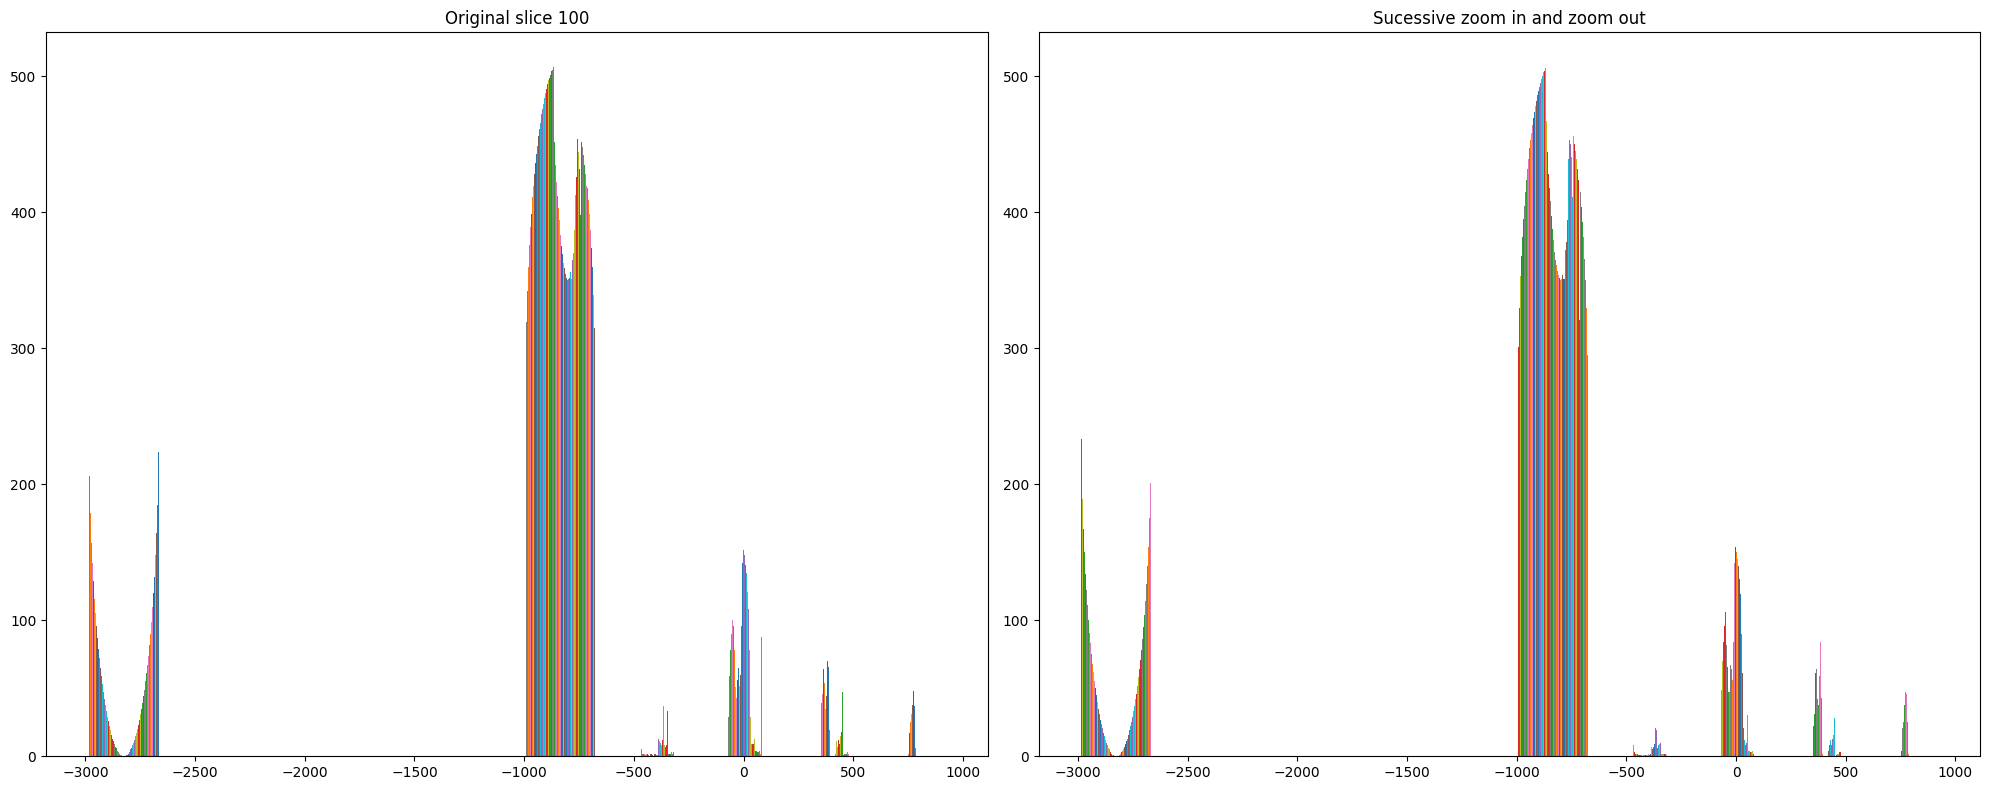

In [ ]:
# Take slice 100 and apply successive zoom in and zoom out
slice_100 = ct_data[:, :, 100].copy()
zoom_in = zoom(slice_100, (4, 4), order=0)  # Nearest-neighbor interpolation
zoom_out = zoom(zoom_in, (0.25, 0.25), order=0)

# Plot histograms before and after
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
ax = axes.ravel()

ax[0].hist(ct_data[:, :, 100])
ax[0].set_title("Original slice 100")

ax[1].hist(zoom_out)
ax[1].set_title("Sucessive zoom in and zoom out")

plt.tight_layout()
plt.show()


In [26]:
# Check if the original slice and the zoomed-out version are exactly the same
are_equal = np.array_equal(ct_data[:, :, 100], zoom_out)
print(f"Are original and zoomed-out slices exactly the same? {are_equal}")

Are original and zoomed-out slices exactly the same? True


In [ ]:
import os
from nibabel import Nifti1Image

# Define output path
output_path = "../results/3702_left_knee_mask_final.nii.gz"
os.makedirs(os.path.dirname(output_path), exist_ok=True)  # Ensure the directory exists

# Save the binary mask as a NIfTI file using the original CT's affine matrix
nifti_img = Nifti1Image(binary_mask, affine=ct_volume.affine)
nib.save(nifti_img, output_path)

print(f"Binary mask saved to: {output_path}")

## Watershed Segmentation and Label Visualization (Summary)

- Performed watershed segmentation on a 3D volume to label regions.
- Extracted unique labels from selected slices to analyze segmentation."
- Visualized segmented slices using `matplotlib` with a custom colormap.

---

**Next steps:** save the segmented mask


In [37]:
import nibabel as nib
import numpy as np

# Load the mask volume
mask_path = "../results/3702_left_knee_mask_final.nii.gz"
mask_volume = nib.load(mask_path)

# Extract 3D mask data
mask_data = mask_volume.get_fdata()  # Already returns a 3D array
assert mask_data.ndim == 3, "Expected a 3D mask volume."

# Store in a variable for clarity if used later
volume_3d = mask_data.copy()

# Get voxel spacing (e.g., in mm) for physical space interpretation
spacing = mask_volume.header.get_zooms()

# Optional sanity check
print(f"Loaded mask volume shape: {volume_3d.shape}")
print(f"Voxel spacing (x, y, z): {spacing}")


Loaded mask volume shape: (512, 512, 216)
Voxel spacing (x, y, z): (np.float32(0.869141), np.float32(0.869141), np.float32(2.0))


In [34]:
from mayavi import mlab

# Visualize the 3D mask using Mayavi
mlab.contour3d(volume_3d, color=(1, 1, 1), opacity=1.0)
mlab.title("Original Mask")
mlab.show()

In [31]:
from scipy.ndimage import distance_transform_edt, label
from skimage.feature import peak_local_max
from skimage.segmentation import watershed

def watershed_segmentation(volume):
    """
    Applies 3D watershed segmentation to a binary volume using distance transform and local maxima.

    Parameters:
    - volume (np.ndarray): A 3D binary mask volume.

    Returns:
    - labels (np.ndarray): A 3D array of watershed-labeled regions.
    """
    # Ensure input is boolean
    binary_volume = volume.astype(bool)
    
    # Compute the Euclidean distance transform
    distance = distance_transform_edt(binary_volume)
    
    # Detect local maxima to serve as markers
    coordinates = peak_local_max(
        distance,
        footprint=np.ones((100, 100, 100)),
        labels=binary_volume,
        exclude_border=False
    )
    
    # Create marker image
    marker_mask = np.zeros(distance.shape, dtype=bool)
    marker_mask[tuple(coordinates.T)] = True
    
    # Label the markers
    markers, _ = label(marker_mask)
    
    # Apply the watershed algorithm
    labels = watershed(-distance, markers, mask=binary_volume)
    
    return labels


In [38]:
labels = watershed_segmentation(volume_3d)

In [36]:
np.unique(labels[:, :, :104]), np.unique(labels[:, :, 107:])

(array([0, 1, 2], dtype=int32), array([0, 1, 2], dtype=int32))

In [ ]:
# Define output path
output_path = "../results/3702_left_knee_mask_segmented.nii.gz"
os.makedirs(os.path.dirname(output_path), exist_ok=True)  # Ensure the directory exists

# Save the segmented mask as a NIfTI file using the mask volume affine matrix
nifti_img = Nifti1Image(labels, affine=mask_volume.affine)
nib.save(nifti_img, output_path)

print(f"Segmented mask saved to: {output_path}")

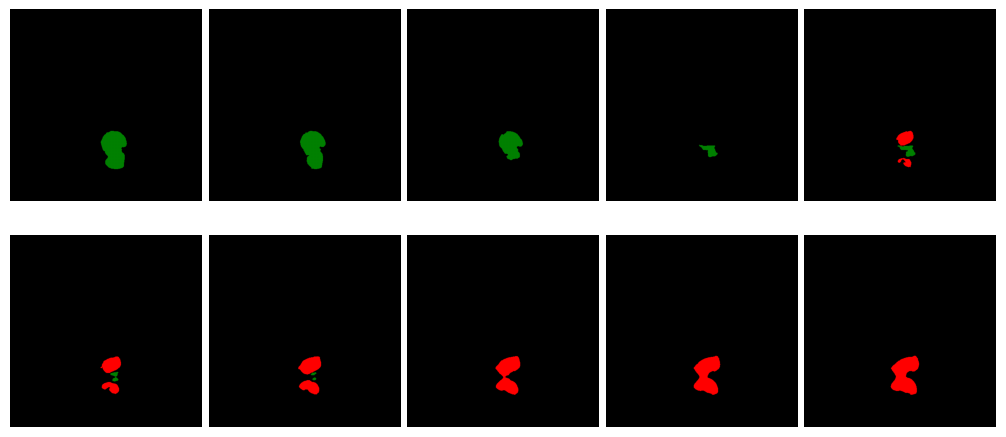

In [39]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# Define a custom colormap with three colors: black, green, red
cmap = ListedColormap(['black', 'green', 'red'])

# Create a 2x5 grid of subplots with specified figure size
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

# Loop through the axes and plot the slices from labels starting at index 100
for i, ax in enumerate(axes.flat):
    # Display the i-th slice (offset by 100) with the defined colormap
    ax.imshow(labels[:, :, i + 100], cmap=cmap, vmin=0, vmax=2)
    ax.axis("off")  # Hide axis ticks and labels for a cleaner look

plt.tight_layout(pad=0.5)  # Adjust spacing to prevent overlap
plt.show()


In [ ]:
def visualize_segments(labels: np.ndarray) -> None:
    """
    Visualize 3D segmentation results showing different anatomical structures.
    
    This function displays segmented anatomical structures (tibia and femur)
    in different colors using 3D contour visualization.
    
    Args:
        labels (np.ndarray): 3D integer array where different values represent
                           different segmented structures:
                           - Label 1: Femur (displayed in red)
                           - Label 2: Tibia (displayed in green)
    
    Returns:
        None: Displays the 3D plot using mlab.show()
    
    Example:
        >>> labels = np.random.randint(0, 3, (50, 50, 50))
        >>> visualize_segments(labels)
    """
    # Extract individual structures from labeled volume
    tibia = (labels == 2).astype(np.float32)
    femur = (labels == 1).astype(np.float32)
    
    # Visualize structures in different colors
    mlab.contour3d(tibia, color=(0, 1, 0))  # Green for tibia
    mlab.contour3d(femur, color=(1, 0, 0))  # Red for femur
    mlab.title("Segmentation Results", size=1)
    mlab.show()

visualize_segments(labels)

## Contour Adjustment


- Calculated contours on mask slices for visual comparison of original vs expanded masks.
- Visualized slices with overlays of contours using efficient, clear plotting loops.
- Created well-defined functions to increase the readability
- Defined the logic for contour expansion and creating random masks
- Saved the expanded masks and randomized masks as a NIfTI file.

---

**Next steps:** use more efficient approach

In [67]:
from typing import List, Tuple, Optional
from skimage import measure

def calculate_contours(mask: np.ndarray, level: float = 0.5) -> List[np.ndarray]:
    """
    Calculate contours in a 2D binary mask.
    
    Args:
        mask (np.ndarray): 2D binary mask
        level (float): Contour level. Default: 0.5
        
    Returns:
        List[np.ndarray]: List of contour coordinate arrays
        
    Example:
        >>> mask = np.zeros((100, 100))
        >>> mask[25:75, 25:75] = 1
        >>> contours = calculate_contours(mask)
        >>> print(f"Found {len(contours)} contours")
    """
    contours = measure.find_contours(mask, level=level)
    return contours


def expand_mask(mask_data: np.ndarray, 
                spacing: Tuple[float, ...], 
                expansion: float = 4.0) -> np.ndarray:
    """
    Expand binary mask contours uniformly using distance transform.
    
    This function uses Euclidean distance transform to achieve uniform expansion
    in all directions, overcoming limitations of coordinate-based methods.
    
    Args:
        mask_data (np.ndarray): 3D binary mask data
        spacing (Tuple[float, ...]): Voxel spacing in mm (x, y, z)
        expansion (float): Expansion distance in mm. Default: 2.0
        
    Returns:
        np.ndarray: Expanded binary mask with same shape as input
        
    Raises:
        ValueError: If mask_data is not 3D or expansion is negative
        
    Example:
        >>> mask = np.random.randint(0, 2, (64, 64, 32))
        >>> spacing = (1.0, 1.0, 2.0)
        >>> expanded = expand_mask(mask, spacing, expansion=3.0)
    """
    if mask_data.ndim != 3:
        raise ValueError("Input mask must be 3D")
    
    if expansion < 0:
        raise ValueError("Expansion distance must be non-negative")
    
    # Initialize output array
    expanded_mask = np.zeros_like(mask_data, dtype=bool)
    
    # Process each 2D slice independently
    for slice_idx in range(mask_data.shape[2]):
        # Get current slice
        current_slice = mask_data[:, :, slice_idx]
        
        # Skip empty slices
        if not np.any(current_slice):
            continue
        
        # Invert mask: foreground becomes background for distance calculation
        inverted_mask = ~current_slice.astype(bool)
        
        # Calculate distance from background pixels to nearest foreground pixel
        distance_map = distance_transform_edt(
            inverted_mask, 
            sampling=spacing[:2]  # Use only x,y spacing for 2D
        )
        
        # Create expanded mask by thresholding distance map
        # Include original foreground and pixels within expansion distance
        expanded_slice = (distance_map <= expansion) | current_slice.astype(bool)
        expanded_mask[:, :, slice_idx] = expanded_slice
    
    return expanded_mask

In [68]:
# Select a subset of slices from the original mask for inspection (slices 120 to 129)
input_masks = mask_data[:, :, 120:130]

# Expand the full 3D mask by the specified physical distance using the spacing info
expanded_mask= expand_mask(mask_data, spacing=spacing)

# Now `expanded_mask` contains the original mask expanded slice-by-slice by 2.0 units
# `dist_map` holds the distance transform of the last processed slice (useful for debugging or visualization)

In [69]:
def calculate_contours(mask: np.ndarray, level: float = 0.5) -> List[np.ndarray]:
    """
    Calculate contours in a 2D binary mask.
    
    Args:
        mask (np.ndarray): 2D binary mask
        level (float): Contour level. Default: 0.5
        
    Returns:
        List[np.ndarray]: List of contour coordinate arrays
        
    Example:
        >>> mask = np.zeros((100, 100))
        >>> mask[25:75, 25:75] = 1
        >>> contours = calculate_contours(mask)
        >>> print(f"Found {len(contours)} contours")
    """
    contours = measure.find_contours(mask, level=level)
    return contours

In [70]:
def show_distance_transform(dist_matrix: np.ndarray) -> None:
    """
    Visualize a distance transform matrix using a heat map.
    
    This function displays the distance transform as a color-coded image
    where intensity represents distance values.
    
    Args:
        dist_matrix (np.ndarray): 2D array containing distance transform values
    
    Returns:
        None: Displays the plot using matplotlib.pyplot.show()
    
    Example:
        >>> dist_matrix = np.random.rand(50, 50)
        >>> show_distance_transform(dist_matrix)
    """
    plt.imshow(dist_matrix, cmap="hot")
    plt.colorbar(label="Distance")
    plt.title("Distance Transform")
    plt.show()

In [71]:
def show_contours(mask: np.ndarray, contours: List[np.ndarray]) -> None:
    """
    Display 2D contours overlaid on a mask image.
    
    This function plots detected contours on top of the original mask image
    using matplotlib for 2D visualization.
    
    Args:
        mask (np.ndarray): 2D binary mask array to display as background
        contours (List[np.ndarray]): List of contour arrays, each containing 
                                   (x, y) coordinates of contour points
    
    Returns:
        None: Displays the plot using matplotlib.pyplot.show()
    
    Example:
        >>> mask = np.zeros((100, 100))
        >>> contours = [np.array([[10, 10], [20, 10], [20, 20]])]
        >>> show_contours(mask, contours)
    """
    # Plot each contour on the image
    for contour in contours:
        plt.plot(contour[:, 1], contour[:, 0])
    
    # Display the mask as background in grayscale
    plt.imshow(mask, cmap="gray")
    plt.show()

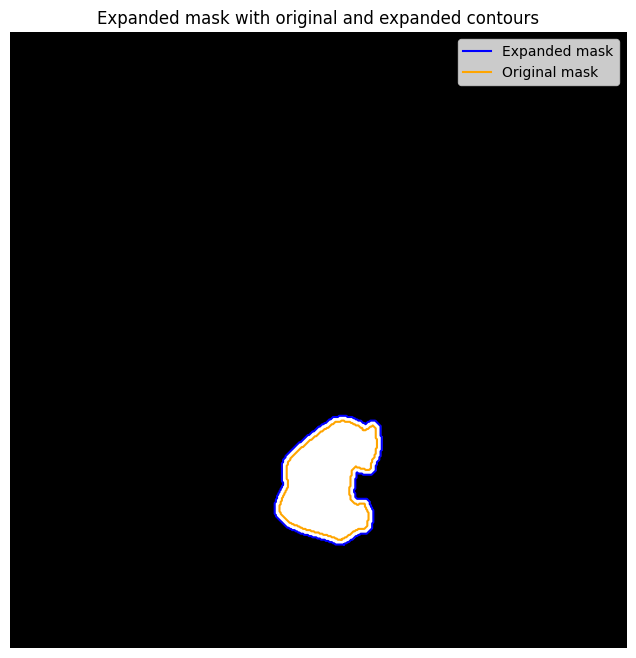

In [72]:
# Calculate contours from slices
contours = calculate_contours(expanded_mask[:, :, 125]) + calculate_contours(input_masks[:, :, 5])

plt.figure(figsize=(20, 8))
plt.imshow(expanded_mask[:, :, 125], cmap='gray')
colors = ['blue', 'orange']  # Distinct colors for contours

# Plot contours efficiently in a loop
for contour, color, label in zip(contours, colors, ['Expanded mask', 'Original mask']):
    plt.plot(contour[:, 1], contour[:, 0], color=color, label=label)

plt.title("Expanded mask with original and expanded contours")
plt.legend()
plt.axis('off')
plt.show()

In [73]:
def create_random_mask(mask_data: np.ndarray, 
                      spacing: Tuple[float, ...], 
                      expansion: float = 2.0,
                      randomness_level: float = 0.5, 
                      seed: Optional[int] = None) -> np.ndarray:
    """
    Create randomized mask variations using signed distance transform.
    
    This function creates controlled randomization by randomly selecting pixels
    within the expansion shell around the original mask boundary.
    
    Args:
        mask_data (np.ndarray): 3D binary mask data
        spacing (Tuple[float, ...]): Voxel spacing in mm (x, y, z)
        expansion (float): Maximum expansion distance in mm. Default: 2.0
        randomness_level (float): Fraction of shell pixels to include (0.0-1.0). Default: 0.5
        seed (Optional[int]): Random seed for reproducibility. Default: None
        
    Returns:
        np.ndarray: Randomized binary mask
        
    Raises:
        ValueError: If randomness_level is not between 0 and 1
        
    Example:
        >>> mask = np.random.randint(0, 2, (64, 64, 32))
        >>> spacing = (1.0, 1.0, 2.0)
        >>> random_mask = create_random_mask(mask, spacing, randomness_level=0.8, seed=42)
    """
    if not 0.0 <= randomness_level <= 1.0:
        raise ValueError("Randomness level must be between 0.0 and 1.0")
    
    # Set random seed for reproducibility
    if seed is not None:
        np.random.seed(seed)
    
    # Initialize output array
    random_mask = np.zeros_like(mask_data)
    
    # Process each 2D slice independently
    for slice_idx in range(mask_data.shape[2]):
        current_slice = mask_data[:, :, slice_idx]
        
        # Skip empty slices
        if not np.any(current_slice):
            continue
        
        # Convert to boolean
        binary_mask = current_slice.astype(bool)
        
        # Calculate distance transforms for signed distance function
        # Distance from background to foreground (positive outside)
        outside_distance = distance_transform_edt(
            ~binary_mask, 
            sampling=spacing[:2]
        )
        
        # Distance from foreground to background (for inside calculation)
        inside_distance = distance_transform_edt(
            binary_mask, 
            sampling=spacing[:2]
        )
        
        # Create signed distance function
        # Positive values outside object, negative values inside
        signed_distance = outside_distance.copy()
        signed_distance[binary_mask] = -inside_distance[binary_mask]
        
        # Create expanded region mask
        expanded_region = signed_distance <= expansion
        
        # Find expansion shell (expanded region minus original mask)
        expansion_shell = expanded_region & ~binary_mask
        
        # Get indices of shell pixels
        shell_indices = np.argwhere(expansion_shell)
        
        if len(shell_indices) == 0:
            # No shell pixels found, keep original mask
            random_mask[:, :, slice_idx] = binary_mask
            continue
        
        # Calculate number of pixels to randomly select
        num_to_select = int(randomness_level * len(shell_indices))
        
        # Randomly select shell pixels
        if num_to_select > 0:
            selected_indices = np.random.choice(
                len(shell_indices), 
                size=num_to_select, 
                replace=False
            )
            
            # Start with original mask
            randomized_slice = binary_mask.copy()
            
            # Add randomly selected shell pixels
            for idx in selected_indices:
                x, y = shell_indices[idx]
                randomized_slice[x, y] = True
                
            random_mask[:, :, slice_idx] = randomized_slice
        else:
            # No pixels to add, keep original
            random_mask[:, :, slice_idx] = binary_mask
    
    return random_mask

In [74]:
randomized_mask = create_random_mask(mask_data, spacing=spacing)

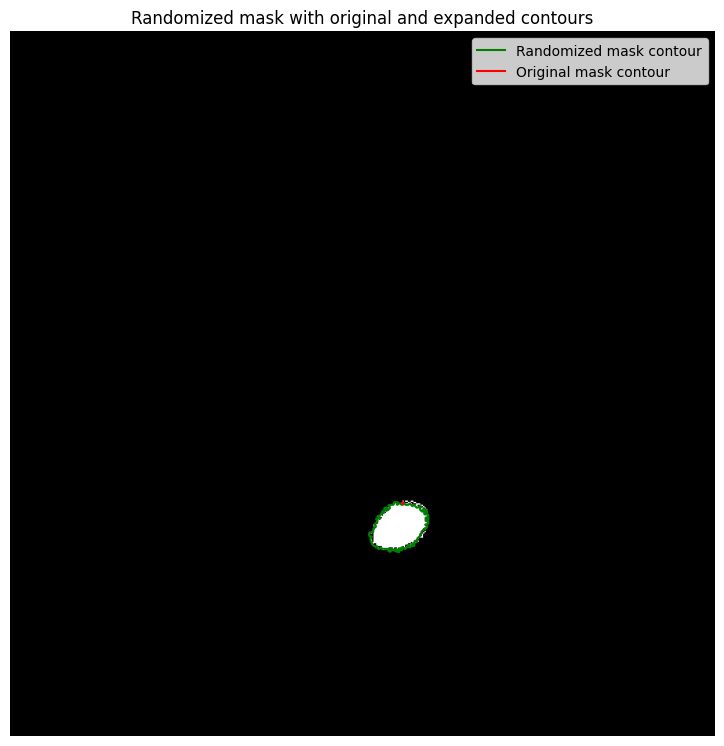

In [75]:
# Calculate contours from the 10th slice of both masks
contours = calculate_contours(randomized_mask[:, :, 10]) + calculate_contours(mask_data[:, :, 10])

plt.figure(figsize=(20, 30))

# Display the 5th slice of randomized_mask in grayscale
plt.subplot(2, 2, 1)
plt.imshow(randomized_mask[:, :, 5], cmap="gray")

# Define colors and labels for contours
colors = ['green', 'red']
labels = ['Randomized mask contour', 'Original mask contour']

# Plot contours efficiently using a loop
for contour, color, label in zip(contours, colors, labels):
    plt.plot(contour[:, 1], contour[:, 0], color=color, label=label)

plt.title("Randomized mask with original and expanded contours")
plt.axis('off')
plt.legend()
plt.show()


In [ ]:
# Define output path
output_path = "../results/3702_left_knee_expanded_mask_1.nii.gz"
os.makedirs(os.path.dirname(output_path), exist_ok=True)  # Ensure the directory exists

# Save the expanded mask as a NIfTI file using the mask volume affine matrix
nifti_img = Nifti1Image(expanded_mask, affine=mask_volume.affine)
nib.save(nifti_img, output_path)

print(f"Expanded mask saved to: {output_path}")

In [ ]:
# Define output path
output_path = "../results/3702_left_knee_randomized_mask_1.nii.gz"
os.makedirs(os.path.dirname(output_path), exist_ok=True)  # Ensure the directory exists

# Save the randomized mask as a NIfTI file using the mask volume affine matrix
nifti_img = Nifti1Image(randomized_mask, affine=mask_volume.affine)
nib.save(nifti_img, output_path)

print(f"Randomized mask saved to: {output_path}")

## Tibial Landmark Detection from 3D CT

- Loaded and isolated the tibia from a segmented CT volume.
- Focused on the top 15% slices (tibial plateau region).
- Applied 2D skeletonization and 3D distance transform.
- Scored skeleton points based on distance, height, and lateral spread.
- Identified medial and lateral landmarks using weighted scoring.
- Visualized tibia and landmarks in 3D using Mayavi.


In [77]:
import nibabel as nib
import numpy as np

# Load the segmented volume
segmented_path = "../results/3702_left_knee_mask_segmented.nii.gz"
segmented_volume = nib.load(segmented_path)

# Extract 3D segmented data
labels = segmented_volume.get_fdata()  # Already returns a 3D array

# Get voxel spacing (e.g., in mm) for physical space interpretation
spacing = segmented_volume.header.get_zooms()

# Optional sanity check
print(f"Loaded mask volume shape: {volume_3d.shape}")
print(f"Voxel spacing (x, y, z): {spacing}")


Loaded mask volume shape: (512, 512, 216)
Voxel spacing (x, y, z): (np.float32(0.869141), np.float32(0.869141), np.float32(2.0))


In [78]:
# Extract tibia mask (assuming label 1 is tibia)
tibia_3d = (labels == 1).astype(np.float32)
tibia_voxels = np.sum(tibia_3d)

In [79]:
# Visualize the Tibia mask using Mayavi
mlab.contour3d(tibia_3d, color=(1, 1, 1))
mlab.title("Tibia")
mlab.show()

In [76]:
import numpy as np
from skimage.morphology import skeletonize
from scipy.ndimage import distance_transform_edt

def find_landmarks(tibia_3d: np.ndarray, 
                   spacing: Tuple[float, float, float],
                   top_percent: float = 15.0,
                   min_x_distance: int = 10) -> Tuple[np.ndarray, np.ndarray]:
    """
    Detect medial and lateral landmarks in tibial plateau region.
    
    This function uses a combination of skeletonization and distance transform
    to identify anatomically relevant landmark points in the tibia bone.
    
    Args:
        tibia_3d (np.ndarray): 3D binary mask of tibia bone
        spacing (Tuple[float, float, float]): Voxel spacing in mm (x, y, z)
        top_percent (float): Percentage of top slices to consider as plateau. Default: 15.0
        min_x_distance (int): Minimum distance from midline in pixels. Default: 10
        
    Returns:
        Tuple[np.ndarray, np.ndarray]: Coordinates of medial and lateral landmarks
                                     as [x, y, z] arrays
        
    Raises:
        ValueError: If tibia_3d is not 3D or contains no foreground pixels
        
    Example:
        >>> tibia = np.random.randint(0, 2, (128, 128, 64))
        >>> spacing = (1.0, 1.0, 2.0)
        >>> medial, lateral = find_landmarks(tibia, spacing)
        >>> print(f"Medial: {medial}, Lateral: {lateral}")
    """
    if tibia_3d.ndim != 3:
        raise ValueError("Input tibia volume must be 3D")
    
    if not np.any(tibia_3d):
        raise ValueError("Input tibia volume contains no foreground pixels")
    
    # Step 1: Identify tibial plateau region
    # Find slices containing tibia data
    z_nonzero = np.any(tibia_3d, axis=(0, 1))
    z_indices = np.where(z_nonzero)[0]
    
    if len(z_indices) == 0:
        raise ValueError("No valid slices found in tibia volume")
    
    # Calculate plateau region (top percentage of slices)
    z_cutoff = int(np.percentile(z_indices, 100 - top_percent))
    
    # Create plateau mask focusing on superior region
    plateau_3d = np.zeros_like(tibia_3d, dtype=bool)
    plateau_3d[:, :, z_cutoff:] = tibia_3d[:, :, z_cutoff:]
    
    print(f"Plateau region: slices {z_cutoff} to {tibia_3d.shape[2]-1}")
    
    # Step 2: Calculate distance transform for depth weighting
    # Distance from each point to nearest background pixel
    distance_map = distance_transform_edt(plateau_3d, sampling=spacing)
    
    # Step 3: Skeletonization to find structural centerlines
    skeleton_points = []
    
    # Process each slice in plateau region
    for z in range(z_cutoff, plateau_3d.shape[2]):
        slice_mask = plateau_3d[:, :, z]
        
        # Skip empty slices
        if not np.any(slice_mask):
            continue
        
        # Apply 2D skeletonization to current slice
        skeleton_2d = skeletonize(slice_mask)
        
        # Extract skeleton coordinates
        skeleton_coords = np.argwhere(skeleton_2d)  # Returns [x, y] coordinates
        
        # Add z-coordinate and convert to [x, y, z] format
        for x, y in skeleton_coords:
            skeleton_points.append([x, y, z])
    
    if len(skeleton_points) == 0:
        raise ValueError("No skeleton points found in plateau region")
    
    skeleton_points = np.array(skeleton_points)
    print(f"Found {len(skeleton_points)} skeleton points")
    
    # Step 4: Calculate weighted scores for landmark selection
    # Extract coordinates for processing
    coords_3d = skeleton_points
    
    # Get distance values at skeleton points
    distance_values = distance_map[coords_3d[:, 0], coords_3d[:, 1], coords_3d[:, 2]]
    
    # Step 5: Establish medial-lateral separation using x-coordinate median
    x_median = np.median(coords_3d[:, 0])
    x_distances = np.abs(coords_3d[:, 0] - x_median)
    
    # Filter points that are sufficiently far from midline
    # This ensures clear medial/lateral separation
    valid_indices = np.where(x_distances > min_x_distance)[0]
    
    if len(valid_indices) == 0:
        # If no points are far enough, use all points
        print("Warning: No points found far from midline, using all skeleton points")
        valid_indices = np.arange(len(coords_3d))
    
    # Filter coordinates and values
    filtered_coords = coords_3d[valid_indices]
    filtered_distances = distance_values[valid_indices]
    filtered_x_distances = x_distances[valid_indices]
    
    # Step 6: Calculate composite weighting score
    # Weight by distance from x-midline (larger separation = better)
    x_weight = 1.0 + (filtered_x_distances / np.max(filtered_x_distances))
    
    # Weight by z-depth (closer to plateau top = better)
    z_scores = 1.0 - (filtered_coords[:, 2] - z_cutoff) / (plateau_3d.shape[2] - z_cutoff)
    
    # Combine distance transform value with positional weights
    composite_scores = filtered_distances * x_weight * z_scores
    
    # Step 7: Select medial and lateral landmarks
    # Split points based on x-coordinate relative to median
    medial_indices = np.where(filtered_coords[:, 0] < x_median)[0]
    lateral_indices = np.where(filtered_coords[:, 0] >= x_median)[0]
    
    if len(medial_indices) == 0 or len(lateral_indices) == 0:
        raise ValueError("Could not find both medial and lateral points")
    
    # Select best points from each side
    medial_best_idx = medial_indices[np.argmax(composite_scores[medial_indices])]
    lateral_best_idx = lateral_indices[np.argmax(composite_scores[lateral_indices])]
    
    medial_landmark = filtered_coords[medial_best_idx]
    lateral_landmark = filtered_coords[lateral_best_idx]
    
    print(f"Selected landmarks:")
    print(f"Medial: [{medial_landmark[0]}, {medial_landmark[1]}, {medial_landmark[2]}]")
    print(f"Lateral: [{lateral_landmark[0]}, {lateral_landmark[1]}, {lateral_landmark[2]}]")
    
    return medial_landmark, lateral_landmark


In [81]:
# Detect Landmarks
medial, lateral =  find_landmarks(tibia_3d, spacing=spacing)

Plateau region: slices 90 to 215
Found 1238 skeleton points
Selected landmarks:
Medial: [343, 277, 97]
Lateral: [406, 287, 96]


In [82]:
# Standard library imports
from typing import List, Tuple, Union

def show_landmarks(volume: np.ndarray, 
                  medial: Union[np.ndarray, Tuple[float, float, float]], 
                  lateral: Union[np.ndarray, Tuple[float, float, float]]) -> None:
    """
    Visualize anatomical landmarks on a 3D volume.
    
    This function displays detected landmark points (medial and lateral)
    overlaid on a semi-transparent 3D volume visualization.
    
    Args:
        volume (np.ndarray): 3D binary array representing the anatomical structure
        medial (Union[np.ndarray, Tuple[float, float, float]]): 3D coordinates 
                                                               of medial landmark
        lateral (Union[np.ndarray, Tuple[float, float, float]]): 3D coordinates 
                                                                of lateral landmark
    
    Returns:
        None: Displays the 3D plot using mlab.show()
    
    Example:
        >>> volume = np.random.randint(0, 2, (50, 50, 50))
        >>> medial = [25, 15, 30]
        >>> lateral = [25, 35, 30]
        >>> show_landmarks(volume, medial, lateral)
    """
    # Display the volume with transparency
    mlab.contour3d(volume, color=(1, 1, 1), opacity=0.3)
    
    # Display landmark points
    mlab.points3d(medial[0], medial[1], medial[2], 
                  color=(1, 0, 0),  # Red for medial
                  scale_factor=4, 
                  resolution=20)
    
    mlab.points3d(lateral[0], lateral[1], lateral[2], 
                  color=(0, 0, 1),  # Blue for lateral
                  scale_factor=4, 
                  resolution=20)
    
    mlab.title("Anatomical Landmarks")
    mlab.show()


In [83]:
show_landmarks(tibia_3d, medial, lateral)